In [1]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv
import pyrealsense2 as rs
import datetime as dt
import time
import csv
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV , cross_val_score
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier , VotingClassifier
from sklearn.metrics import accuracy_score # Accuracy metrics 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import logging
import pickle 
import rospy
import moveit_commander
import sys
from math import pi
import moveit_msgs.msg
import geometry_msgs.msg
from geometry_msgs.msg import TwistStamped
from subprocess import *
import serial
from time import sleep




In [2]:
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions

In [3]:
font = cv2.FONT_HERSHEY_COMPLEX
org = (20,100)
fontScale = .5
thickness = 1 
color = (0,150,255)
realsense_ctx = rs.context()
connected_devices = [] # List of serial numbers for present cameras
for i in range(len(realsense_ctx.devices)):
        detected_camera =  realsense_ctx.devices[i].get_info(rs.camera_info.serial_number)
        print(f"{detected_camera}")
        connected_devices.append(detected_camera)
        
device = connected_devices[0] # In this example we are only using one camera    
 #device = connected_devices[1] # In this example we are only using one camera    
print(f"{device}")
pipeline = rs.pipeline()    
config = rs.config()    
background_removed_color = 153 # Grey

config.enable_device(device)
stream_res_x = 640
stream_res_y = 480
stream_fps = 30
config.enable_stream(rs.stream.depth, stream_res_x, stream_res_y, rs.format.z16, stream_fps)
config.enable_stream(rs.stream.color, stream_res_x, stream_res_y, rs.format.bgr8, stream_fps)
profile = pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)
# ====== Get depth Scale ======
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
# ====== Set clipping distance ======
clipping_distance_in_meters = 2
clipping_distance = clipping_distance_in_meters / depth_scale

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while True:
        start_time = dt.datetime.today().timestamp() # Necessary for FPS calculations

                # Get and align frames
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        aligned_depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()

        if not aligned_depth_frame or not color_frame:
            continue

            # Process images
        # Wait for the next frame from the RealSense camera
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()

        if not depth_frame or not color_frame:
            continue

        # Convert the depth frame to a numpy array
        depth_image = np.asanyarray(depth_frame.get_data())

        # Convert the color frame to a numpy array
        color_image = np.asanyarray(color_frame.get_data())
        color_image = cv2.flip(color_image, 1) 
        
        # Apply colormap on depth image (for visualization)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            
        image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
                       # Image is no longer writeable
        
        # Recolor Feed
               
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
        
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

pipeline.stop()
cv2.destroyAllWindows()

819312070137
819612071001
819312070137


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
pipeline.stop()
cv2.destroyAllWindows()

In [5]:
num_coords = len(results.pose_landmarks.landmark)+len(results.face_landmarks.landmark)+len(results.right_hand_landmarks.landmark)
num_coords

AttributeError: 'NoneType' object has no attribute 'landmark'

In [8]:
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [24]:
connected_devices = [] # List of serial numbers for present cameras
for i in range(len(realsense_ctx.devices)):
        detected_camera =  realsense_ctx.devices[i].get_info(rs.camera_info.serial_number)
        print(f"{detected_camera}")
        connected_devices.append(detected_camera)
camera_input = input("Select camera: ")
if camera_input == '0':
        camera_id = connected_devices[0]
elif camera_input == '1':
        camera_id = connected_devices[1]
print(camera_input)

819312070137
819612071001
0


In [25]:
file_name = f'coordsV2_{camera_id}.csv'
file_path = os.path.join('/home/non/catkin_ws/src/robot_control/scripts/', file_name)
with open(file_path, mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)


In [9]:
def extract_keypoints(results):
    poseLSTM = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    faceLSTM = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lhLSTM = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rhLSTM = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([poseLSTM, faceLSTM, lhLSTM, rhLSTM])

In [ ]:
#Give_pen,Take_pen,Give_tape,take_tape,Give_box,take_box, up, down, left,right, Grip, Release ,Input_2, Need_assist

In [27]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('NonV2_data') 

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Non_data_add') 


In [19]:
#Original
# Directory for saving images and data
# model_folder = 'Model'
# os.makedirs(model_folder, exist_ok=True)  # Create the "Model" folder if it doesn't exist
class_name = input("Enter the class name: ")


try: 
    
    os.makedirs(os.path.join(DATA_PATH, class_name), exist_ok=True)
    
except:
            pass

font = cv2.FONT_HERSHEY_COMPLEX
org = (20,100)
fontScale = .5
thickness = 1 
color = (0,150,255)
realsense_ctx = rs.context()
connected_devices = [] # List of serial numbers for present cameras
for i in range(len(realsense_ctx.devices)):
        detected_camera =  realsense_ctx.devices[i].get_info(rs.camera_info.serial_number)
        print(f"{detected_camera}")
        connected_devices.append(detected_camera)
camera_input = input("Select camera: ")
if camera_input == '0':
        camera_id = connected_devices[0]
elif camera_input == '1':
        camera_id = connected_devices[1]
print(camera_input)    
device = camera_id # In this example we are only using one camera  


print(camera_id)
# print(camera_id)



pipeline = rs.pipeline()    
config = rs.config()    
background_removed_color = 153 # Grey

config.enable_device(device)
stream_res_x = 640
stream_res_y = 480
stream_fps = 30
config.enable_stream(rs.stream.depth, stream_res_x, stream_res_y, rs.format.z16, stream_fps)
config.enable_stream(rs.stream.color, stream_res_x, stream_res_y, rs.format.bgr8, stream_fps)
profile = pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)
# ====== Get depth Scale ======
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
# ====== Set clipping distance ======
clipping_distance_in_meters = 2
clipping_distance = clipping_distance_in_meters / depth_scale

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    start_time = time.time()  
    while True:
        
        # start_time = dt.datetime.today().timestamp() # Necessary for FPS calculations

        # count down
        current_time = time.time()
        elapsed_time = current_time - start_time
        remaining_time = max(0, 30 - elapsed_time)  # Countdown for 30 seconds

        if remaining_time == 0:
            break

                # Get and align frames
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        aligned_depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()

        if not aligned_depth_frame or not color_frame:
            continue

            # Process images
        # Wait for the next frame from the RealSense camera
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        
        if not depth_frame or not color_frame:
            continue

        # Convert the depth frame to a numpy array
        depth_image = np.asanyarray(depth_frame.get_data())

        # Convert the color frame to a numpy array
        color_image = np.asanyarray(color_frame.get_data())
        color_image = cv2.flip(color_image, 1) 
        
        # Apply colormap on depth image (for visualization)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            
        image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
                       # Image is no longer writeable
        
        # Recolor Feed
               
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
        
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten() if results.pose_landmarks else np.zeros(33*4) )
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten() if results.face_landmarks else np.zeros(468*3))

            # Extract Right hand landmarks
            # right_hand = results.right_hand_landmarks.landmark
            # right_hand_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in right_hand]).flatten() if results.right_hand_landmarks else np.zeros(21*3))
            
            # Extract Left hand landmarks
            left_hand = results.left_hand_landmarks.landmark
            left_hand_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in left_hand]).flatten()) if results.left_hand_landmarks else np.zeros(21*3)

            # Concate rows
            # row = pose_row+face_row+right_hand_row+left_hand_row
            row = pose_row+face_row+left_hand_row
            
            # Append class name 
            row.insert(0, class_name)
            # print(camera_id)
            #row.append(camera_id)
            num_frames = 30

           
            
        
            
            
            # Create a folder for the class if it doesn't exist for Camera 
            # keypoints = extract_keypoints(results)
            # npy_path = os.path.join(DATA_PATH, class_name, str(i))
            # np.save(npy_path, keypoints)
            file_path = os.path.join(DATA_PATH, class_name, f"camera_screenshot_{i + 1}.png")
        
            cv2.imwrite(file_path, image)
        
    

            file_name = f'coords_819312070137.csv'
            file_path = os.path.join('/home/non/catkin_ws/src/robot_control/scripts/', file_name)
            with open(file_path, mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(row)

            # Display the countdown on the screen
            countdown_text = f"Countdown: {int(remaining_time)} seconds"
            cv2.putText(image, countdown_text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        
            
            # with open('coords_test0.csv', mode='a', newline='') as f:
            #     csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            #     csv_writer.writerow(row) 

            # with open('coords_test1.csv', mode='a', newline='') as f:
            #     csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            #     csv_writer.writerow(row) 
                # Export to CSV for Camera 1
            # Full path to the CSV file
            
            # with open(os.path.join(class_folder, f'coords_{camera_id}.csv'), mode='a', newline='') as f1:
            #     csv_writer1 = csv.writer(f1, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            #     csv_writer1.writerow(row)
            
             
            
        except:
            pass



        cv2.imshow('Raw Webcam Feed', image)
        

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

pipeline.stop()
cv2.destroyAllWindows()

819312070137
819612071001
0
819312070137


In [ ]:
df = pd.read_csv('coords.csv')

In [10]:
df = pd.read_csv('coords_819312070137.csv')

In [3]:
df = pd.read_csv('coords_ROMAN_Non.csv')

In [4]:
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z520,v520,x521,y521,z521,v521,x522,y522,z522,v522
0,Hold,0.407733,0.129086,-0.778690,0.993342,0.421445,0.090329,-0.737180,0.993019,0.434254,...,-0.078738,0.0,0.911478,0.763253,-0.085874,0.0,0.918760,0.787047,-0.091987,0.0
1,Hold,0.405080,0.119946,-0.982599,0.993911,0.419926,0.084866,-0.928936,0.993197,0.433784,...,-0.081532,0.0,0.907795,0.763564,-0.088705,0.0,0.912692,0.788697,-0.094718,0.0
2,Hold,0.397699,0.109015,-0.836984,0.994504,0.419621,0.072088,-0.792933,0.993758,0.433126,...,-0.077996,0.0,0.909169,0.768035,-0.084063,0.0,0.914087,0.792701,-0.089030,0.0
3,Hold,0.395727,0.105420,-0.799126,0.994938,0.418676,0.067525,-0.756440,0.993735,0.432624,...,-0.073175,0.0,0.910434,0.768192,-0.078608,0.0,0.918212,0.791781,-0.082382,0.0
4,Hold,0.394592,0.100825,-0.968101,0.995398,0.418038,0.063968,-0.916498,0.994151,0.432285,...,-0.080001,0.0,0.810127,0.742485,-0.083544,0.0,0.814252,0.768813,-0.084207,0.0


In [5]:
df.tail()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z520,v520,x521,y521,z521,v521,x522,y522,z522,v522
18268,Leave,0.666923,0.221269,-0.332770,0.999916,0.681231,0.184471,-0.281154,0.999896,0.688187,...,-0.010495,0.0,0.761469,0.751355,-0.012388,0.0,0.770109,0.756443,-0.013085,0.0
18269,Leave,0.666389,0.221412,-0.330658,0.999913,0.680677,0.184509,-0.279750,0.999891,0.687673,...,-0.011337,0.0,0.761803,0.751660,-0.013362,0.0,0.770183,0.756739,-0.014185,0.0
18270,Leave,0.665702,0.221367,-0.328337,0.999914,0.680188,0.184508,-0.277179,0.999893,0.687307,...,-0.011282,0.0,0.762636,0.750789,-0.013221,0.0,0.771330,0.756428,-0.013938,0.0
18271,Leave,0.665668,0.221217,-0.329806,0.999911,0.680080,0.184319,-0.278807,0.999888,0.687194,...,-0.012590,0.0,0.761262,0.750477,-0.014909,0.0,0.770216,0.755539,-0.015873,0.0
18272,Leave,0.665525,0.220826,-0.332939,0.999908,0.679972,0.184006,-0.281722,0.999884,0.687122,...,-0.012289,0.0,0.762541,0.751612,-0.014588,0.0,0.770805,0.756889,-0.015552,0.0


In [7]:
# Set up logging
logging.basicConfig(filename='training_grid.log', level=logging.INFO)

In [6]:
X = df.drop('class', axis=1) # features
y = df['class'] # target value

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [9]:
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression()),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    # 'svm': make_pipeline(StandardScaler(), SVC()),
    # 'knn': make_pipeline(StandardScaler(), KNeighborsClassifier())
}

In [10]:
param_grids = {
    'lr': {'logisticregression__C': [0.1, 1, 10]},
    'rc': {'ridgeclassifier__alpha': [0.1, 1, 10]},
    'rf': {'randomforestclassifier__n_estimators': [50, 100, 200]},
    'gb': {'gradientboostingclassifier__n_estimators': [50, 100, 200], 'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2]},
    # 'svm': {'svc__C': [0.1, 1, 10]},
    # 'knn': {'kneighborsclassifier__n_neighbors': [3, 5, 7]}
}

In [ ]:
fit_models = {}
for algo, pipeline in pipelines.items():
    #model = LogisticRegression(solver='lbfgs', max_iter=30000000000000000)
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [11]:

# Train models using grid search
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, param_grid=param_grids[algo], cv=5)
    model.fit(X_train, y_train)
    fit_models[algo] = model.best_estimator_

/home/non/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/non/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [ ]:
# Ensemble voting classifier
ensemble_model = VotingClassifier(estimators=list(fit_models.items()), voting='hard')
ensemble_model.fit(X_train, y_train)

In [9]:
# Ensemble voting classifier
ensemble_model = VotingClassifier(estimators=list(fit_models.items()), voting='soft')
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier())]))],
                 voting='soft')

In [10]:
  # Model evaluation using cross-validation
cv_results = {}
for algo, model in fit_models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_results[algo] = cv_scores.mean()

In [11]:
   # Save models
with open('Data_train5_Non.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

In [ ]:
   # Save models
with open('body_languageV2.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

logging.info("Models trained successfully.")
logging.info("Cross-validation results:")
for algo, score in cv_results.items():
    logging.info(f"{algo}: {score}")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model


In [ ]:
fit_models

In [ ]:
fit_models['rc'].predict(X_test)

In [ ]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

In [ ]:
fit_models['rf'].predict(X_test)

In [ ]:
with open('body_language.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

In [ ]:
with open('body_language.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report

In [ ]:
fit_models['rf'].predict(X_test)

In [ ]:
model = pickle.load(open('body_language.pkl','rb'))

In [ ]:
fit_models['rf'].predict(X_test)

In [ ]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.svm import SVC

In [13]:
y_pred = model.predict(X_test)

In [14]:
# Get unique class labels from the true labels
class_labels = list(set(y_test))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

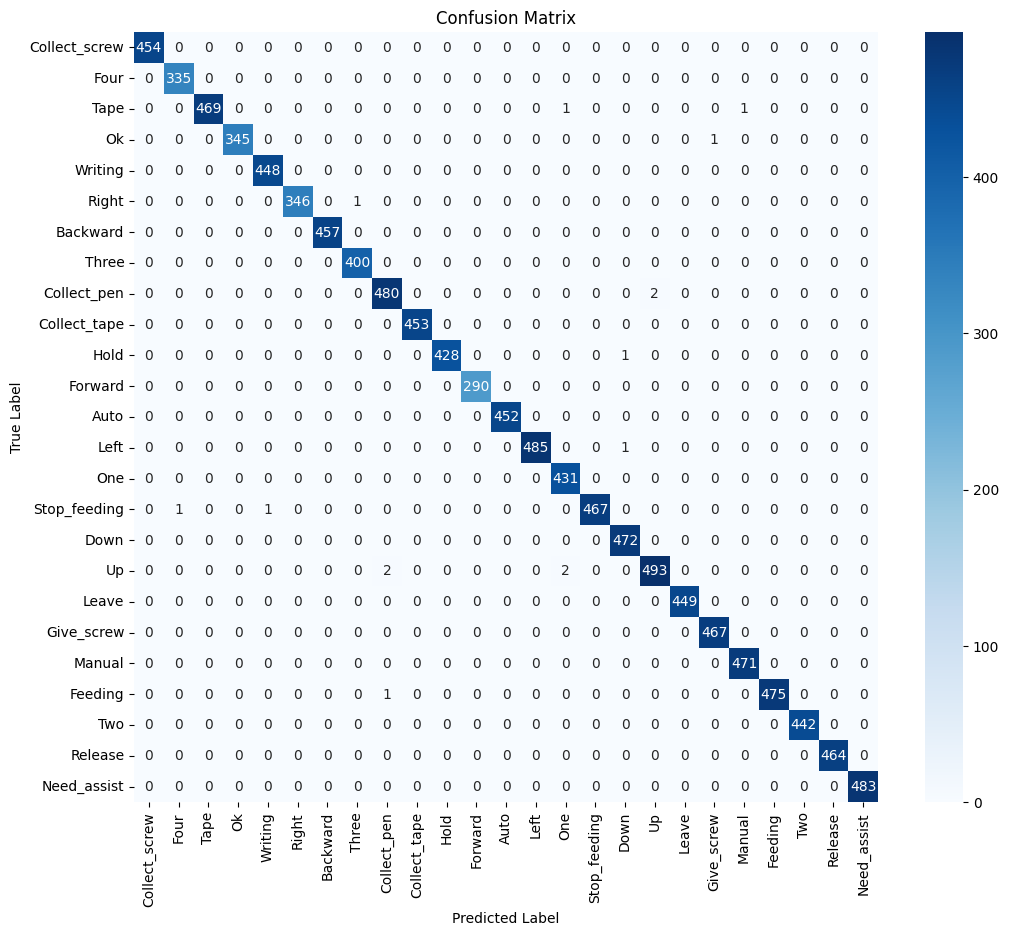

In [15]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
np.diag(cm).sum()

In [ ]:
np.diag(cm).sum()/cm.sum().sum()

In [ ]:
TP = cm[0, 0]
FP = cm[0, :].sum() - TP
FN = cm[:, 0].sum() - TP
TN = cm.sum() - (TP + FP + FN)


In [ ]:
# Print the values
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

In [ ]:
# Calculate Accuracy
accuracy = (TP + TN) / cm.sum()

# Calculate Precision
precision = TP / (TP + FP)

# Calculate Recall
recall = TP / (TP + FN)

# Calculate F1 Score
f1_score = (2 * precision * recall) / (precision + recall)

# Print the values
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

In [ ]:
# Assuming your model is a scikit-learn model with the classes_ attribute
class_names = model.classes_

for i in range(cm.shape[0]):
    TP = cm[i, i]
    FP = cm[i, :].sum() - TP
    FN = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    # Calculate Accuracy, Precision, Recall, and F1 Score
    accuracy = (TP + TN) / cm.sum()
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Print the results with real class names
    print(f"Class {class_names[i]} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")


In [ ]:
model

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.8
font = cv2.FONT_HERSHEY_COMPLEX
org = (20,100)
fontScale = .5
thickness = 1 
color = (0,150,255)
realsense_ctx = rs.context()
connected_devices = [] # List of serial numbers for present cameras
for i in range(len(realsense_ctx.devices)):
        detected_camera =  realsense_ctx.devices[i].get_info(rs.camera_info.serial_number)
        print(f"{detected_camera}")
        connected_devices.append(detected_camera)
        
device = connected_devices[0] # In this example we are only using one camera    
pipeline = rs.pipeline()    
config = rs.config()    
background_removed_color = 153 # Grey

config.enable_device(device)
stream_res_x = 640
stream_res_y = 480
stream_fps = 30
config.enable_stream(rs.stream.depth, stream_res_x, stream_res_y, rs.format.z16, stream_fps)
config.enable_stream(rs.stream.color, stream_res_x, stream_res_y, rs.format.bgr8, stream_fps)
profile = pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)
# ====== Get depth Scale ======
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
# ====== Set clipping distance ======
clipping_distance_in_meters = 2
clipping_distance = clipping_distance_in_meters / depth_scale

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while True:
        start_time = dt.datetime.today().timestamp() # Necessary for FPS calculations

                # Get and align frames
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        aligned_depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()

        if not aligned_depth_frame or not color_frame:
            continue

            # Process images
        # Wait for the next frame from the RealSense camera
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()

        if not depth_frame or not color_frame:
            continue

        # Convert the depth frame to a numpy array
        depth_image = np.asanyarray(depth_frame.get_data())

        # Convert the color frame to a numpy array
        color_image = np.asanyarray(color_frame.get_data())
        color_image = cv2.flip(color_image, 1) 
        
        # Apply colormap on depth image (for visualization)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            
        image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
                       # Image is no longer writeable
        
        # Recolor Feed
               
               
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
        
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

             # Extract Right hand landmarks
            # right_hand = results.right_hand_landmarks.landmark
            # right_hand_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in right_hand]).flatten())
            
             # Extract Left hand landmarks
            left_hand = results.left_hand_landmarks.landmark
            left_hand_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in left_hand]).flatten())

            # Concate rows
            # row = pose_row+face_row+right_hand_row+left_hand_row
            row = pose_row+face_row+left_hand_row
            
            
            
            X = pd.DataFrame([row])
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            #print(body_language_class, body_language_prob)
            max_body_language_prob = round(body_language_prob[np.argmax(body_language_prob)])
            
            if max_body_language_prob > threshold:
                # Grab ear coords
                coords = tuple(np.multiply(
                                np.array(
                                    (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                            , [640,480]).astype(int))
                

                cv2.rectangle(image, 
                            (coords[0], coords[1]+5), 
                            (coords[0]+len(body_language_class)*20, coords[1]-30), 
                            (245, 117, 16), -1)
                cv2.putText(image, body_language_class, coords, 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                # Get status box
                cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
                
                # Display Class
                cv2.putText(image, 'CLASS'
                            , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, body_language_class.split(' ')[0]
                            , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                # Display Probability
                cv2.putText(image, 'PROB'
                            , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
                            , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
        except:
            pass
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

pipeline.stop()
cv2.destroyAllWindows()